In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, avg, expr, lit, year
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GeneralizedLinearRegression, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

Start Spark Session

In [2]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1 - Models")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '8g')
    .config('spark.executor.memory', '8g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/08/20 11:57:09 WARN Utils: Your hostname, LAPTOP-RELH58H1 resolves to a loopback address: 127.0.1.1; using 172.19.22.4 instead (on interface eth0)
23/08/20 11:57:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/20 11:57:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Load Data

In [3]:
shooting_trips = spark.read.parquet(f'../data/curated/onehot_shooting_data.parquet/*')
taxi_trips = spark.read.parquet(f'../data/curated/onehot_taxi_data.parquet/*')

In [4]:
# Function to count number of rows in data
def calculate_total_rows(dataframe):
    total_rows = 0
    total_rows += dataframe.count()
    return total_rows

size_of_shooting_data = calculate_total_rows(shooting_trips)
print("Size of aggregated shooting trips:", size_of_shooting_data)

size_of_taxi_data = calculate_total_rows(taxi_trips)
print("Size of aggregated taxi trips:", size_of_taxi_data)

Size of aggregated shooting trips: 300549


Size of aggregated taxi trips: 4240679


Adding column to indicate shooting so both pieces of data can be used to train the model

In [5]:
shooting_trips = shooting_trips.withColumn("Shooting", lit(1))
taxi_trips = taxi_trips.withColumn("Shooting", lit(0))

Merge Dataframes to train model

In [6]:
# Define the common columns to select
selected_columns = ["Date", "Weekend", "number_of_trips", "LocationID_encoded", "Month_encoded", "Hour_encoded", "Shooting"]
    
# Select the desired columns from both DataFrames
shooting_trips_selected = shooting_trips.select(*selected_columns)
taxi_trips_selected = taxi_trips.select(*selected_columns)
    
# Union the selected DataFrames
combined_df = shooting_trips_selected.union(taxi_trips_selected)

In [7]:
# Function to count number of rows in data
def calculate_total_rows(dataframe):
    total_rows = 0
    total_rows += dataframe.count()
    return total_rows

size_of_training_data = calculate_total_rows(combined_df)
print("Size of aggregated shooting trips:", size_of_training_data)

Size of aggregated shooting trips: 4541228


Seeing Distribution of trips per hour

In [ ]:
# Subsample 10% of the DataFrame
sampled_df = combined_df.sample(False, 0.1)

# Convert the sampled Spark DataFrame to a Pandas DataFrame
sampled_pandas_df = sampled_df.toPandas()

KeyboardInterrupt: 

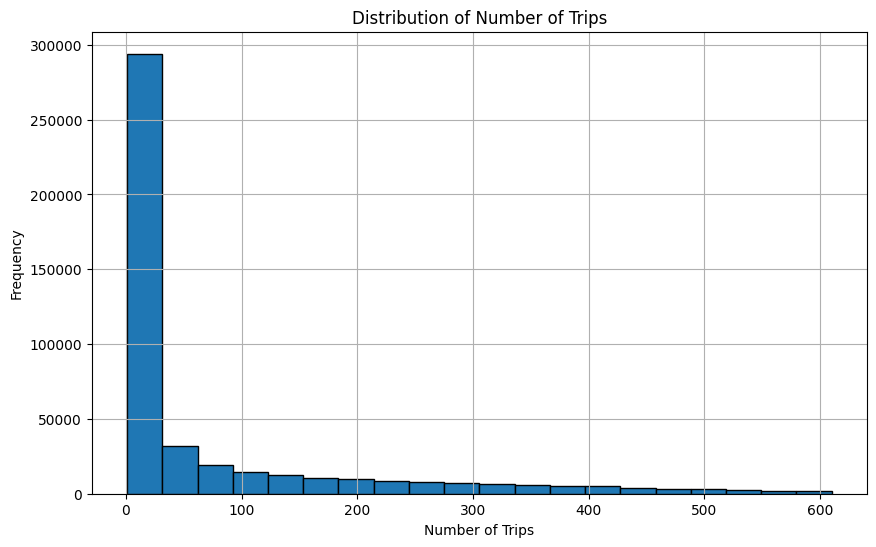

In [ ]:
# Assuming the sampled_pandas_df DataFrame contains the necessary columns including 'number_of_trips'
plt.figure(figsize=(10, 6))
plt.hist(sampled_pandas_df['number_of_trips'], bins=20, edgecolor='k')
plt.title('Distribution of Number of Trips')
plt.xlabel('Number of Trips')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


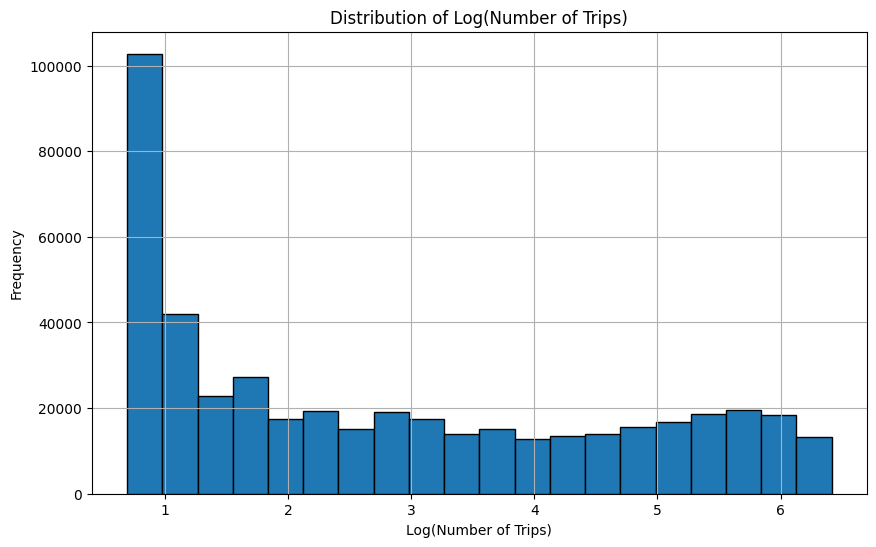

In [ ]:
# Assuming the sampled_pandas_df DataFrame contains the necessary columns including 'number_of_trips'

# Apply log transformation to the 'number_of_trips' column
sampled_pandas_df['log_number_of_trips'] = np.log1p(sampled_pandas_df['number_of_trips'])

plt.figure(figsize=(10, 6))
plt.hist(sampled_pandas_df['log_number_of_trips'], bins=20, edgecolor='k')
plt.title('Distribution of Log(Number of Trips)')
plt.xlabel('Log(Number of Trips)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Split Dataframes into training (2016-2018) and testing (2019)

In [8]:
# Assuming the 'Date' column is of DateType
combined_df = combined_df.withColumn('Year', year(combined_df['Date']))

# Filter for years 2016, 2017, and 2018
df_2016_to_2018 = combined_df.filter((combined_df['Year'] >= 2016) & (combined_df['Year'] <= 2018))
# Filter for the year 2019
df_2019 = combined_df.filter(combined_df['Year'] == 2019)

# Drop the 'Year' column
df_2016_to_2018 = df_2016_to_2018.drop('Year')
df_2019 = df_2019.drop('Year')

# Drop the 'Year' column if needed
df_2016_to_2018 = df_2016_to_2018.drop('Year')
df_2019 = df_2019.drop('Year')

SVM - It was predicting negative numbers - so made those = 0

In [10]:
# Load your preprocessed and merged train and test datasets
train_data_preprocessed = df_2016_to_2018
test_data_preprocessed = df_2019

# Define the feature columns
feature_columns = ["Weekend", "LocationID_encoded", "Month_encoded", "Hour_encoded", "Shooting"]

# Create a VectorAssembler for assembling features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a GeneralizedLinearRegression model with appropriate parameters for SVR-like regression
svr_regressor = GeneralizedLinearRegression(
    labelCol="number_of_trips",
    featuresCol="features",
    family="gaussian",  # Gaussian family for SVR-like regression
    link="identity",    # Identity link function
    maxIter=50,         # Number of iterations
    regParam=0.01        # Regularization parameter
)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, svr_regressor])

# Train the SVR-like model
svr_model = pipeline.fit(train_data_preprocessed)

# Make predictions on the test data
predictions = svr_model.transform(test_data_preprocessed)

# Ensure that predictions are non-negative
predictions = predictions.withColumn('prediction', expr('CASE WHEN prediction < 0 THEN 0 ELSE prediction END'))

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="number_of_trips", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r_squared = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

# Show RMSE and R-squared
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)


ConnectionRefusedError: [Errno 111] Connection refused

Feature Importance

In [ ]:
# Get the coefficients from the trained model
coefficients = svr_model.stages[-1].coefficients

# Map coefficients to their corresponding feature names
feature_importance = dict(zip(feature_columns, coefficients))

# Sort the feature importance dictionary by absolute value of coefficients
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the sorted feature importance
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


Hour_encoded: -245.93024554674093
Month_encoded: -237.27022209625127
Shooting: -234.48369201364176
Weekend: 1.7490229654276124
LocationID_encoded: 0.0


Save SVM Predictions

In [10]:
# Save the DataFrame as a Parquet file
output_path = "../data/curated/SVM_predictions.parquet"
predictions.write.parquet(output_path, mode="overwrite")

print("DataFrame saved as Parquet file.")

DataFrame saved as Parquet file.


Linear Regression

In [9]:
# Load your preprocessed and merged train and test datasets
train_data_preprocessed = df_2016_to_2018
test_data_preprocessed = df_2019

# Define the feature columns
feature_columns = ["Weekend", "LocationID_encoded", "Month_encoded", "Hour_encoded", "Shooting"]

# Create a VectorAssembler for assembling features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Train and evaluate Linear Regression models
linear_regressor = LinearRegression(
    labelCol="number_of_trips",
    featuresCol="features",
    regParam=0.0,           # Set regParam to 0 for no regularization
    elasticNetParam=0.0,    # Set elasticNetParam to 0 for no regularization
    maxIter=100
)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, linear_regressor])

# Train the Linear Regression model
linear_model = pipeline.fit(train_data_preprocessed)

# Make predictions on the test data
predictions = linear_model.transform(test_data_preprocessed)

# Ensure that predictions are non-negative
predictions = predictions.withColumn('prediction', expr('CASE WHEN prediction < 0 THEN 0 ELSE prediction END'))

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="number_of_trips", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r_squared = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

# Show RMSE and R-squared
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)


23/08/20 11:57:54 WARN Instrumentation: [1f46d46a] regParam is zero, which might cause numerical instability and overfitting.
23/08/20 11:57:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/20 11:58:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/08/20 11:58:09 WARN Instrumentation: [1f46d46a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Root Mean Squared Error (RMSE): 67.69356292262097
R-squared: 0.6419236055575865


Feature Importance

In [10]:
# Get the coefficients from the trained model
coefficients = linear_model.stages[-1].coefficients

# Map coefficients to their corresponding feature names
feature_importance = dict(zip(feature_columns, coefficients))

# Sort the feature importance dictionary by absolute value of coefficients
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the sorted feature importance
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Hour_encoded: -247.3826084301114
Month_encoded: -238.72067294909752
Shooting: -235.93559381640418
Weekend: 1.7501939078318434
LocationID_encoded: 0.0


Save Linear Regression Model

In [11]:
# Save the DataFrame as a Parquet file
output_path = "../data/curated/LinearRegression_predictions.parquet"
predictions.write.parquet(output_path, mode="overwrite")

print("DataFrame saved as Parquet file.")

DataFrame saved as Parquet file.
